In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import maxflow


def display_image(window_name, img, window_1_name=None, img_1=None):
    """
    Displays image with given window name.
    :param window_name: name of the window
    :param img: image object to display
    """
    if window_1_name is not None and img_1 is not None:
        plt.figure(figsize=(15, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap="gray")
        plt.title(window_name)
        plt.subplot(1, 2, 2)
        plt.imshow(img_1, cmap="gray")
        plt.title(window_1_name)
    else:
        plt.imshow(img, cmap="gray")
        plt.title(window_name)
        plt.show()

## Task 3.
Denoise the binary image using a Markov random field.  For cut, use max-flow/min-cutalgorithm.  Read a noisy binary imagenoise.png

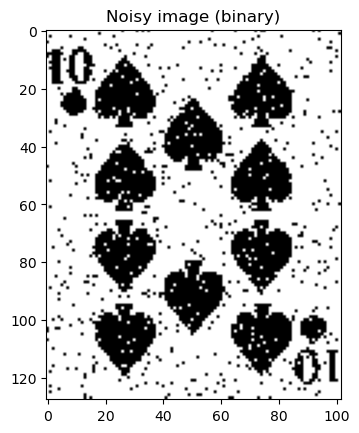

Noisy Img shape: (128, 102)
Noisy Img dtype: uint8 <--- we have to convert it to float as in the provided template maxflow exepts float data type


In [2]:
# set image path
img_path = './images/noise.png'
# read imgs
noisy_img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
display_image('Noisy image (binary)', noisy_img)

print(f"Noisy Img shape: {noisy_img.shape}")
print(f"Noisy Img dtype: {noisy_img.dtype} <--- we have to convert it to float as in the provided template maxflow exepts float data type")



3.1.  Create a graph for the image using all the pixels as nodes. 



In [3]:
def unary_costs(img, rho: float):
    """
    Computes unary costs for given image for source and sink.
    :param img: image object
    :param rho: rho value
    :return: unary cost matrixes for source and sink
    """
    indexes_black = np.where(img == 0)
    indexes_white = np.where(img == 1)
    costs_matrix_source = np.zeros(img.shape)
    costs_matrix_sink = np.zeros(img.shape)

    costs_matrix_source[indexes_black] = rho
    costs_matrix_source[indexes_white] = 1 - rho

    costs_matrix_sink[indexes_black] = 1 - rho
    costs_matrix_sink[indexes_white] = rho
    
    return -np.log(costs_matrix_source), -np.log(costs_matrix_sink)

def pairwise_costs(img, pairwise_cost_same: float, pairwise_cost_diff: float, direction: str):
    """
    Computes pairwise costs for given image.
    :param img: image object
    :param pairwise_cost_same: pairwise costs for same labels
    :param pairwise_cost_diff: pairwise costs for different labels
    :param direction: direction of the pairwise costs. "horizontal" or "vertical"
    :return: pairwise costs
    """
    pairwise_costs_matrix = np.zeros((img.shape[0], img.shape[1]))
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if direction == "horizontal":
                if j > 1 :
                    if img[i, j] == img[i, j-1]:
                        pairwise_costs_matrix[i, j] = pairwise_cost_same
                    else:
                        pairwise_costs_matrix[i, j] = pairwise_cost_diff
                else:
                    pairwise_costs_matrix[i, j] = 0
            else:
                if i > 1:
                    if img[i, j] == img[i-1, j]:
                        pairwise_costs_matrix[i, j] = pairwise_cost_same
                    else:
                        pairwise_costs_matrix[i, j] = pairwise_cost_diff
                else:
                    pairwise_costs_matrix[i, j] = 0

    return pairwise_costs_matrix

Each pixel (node) are connected to the “source node” and the “sink node” with directed edges as well as the directed edges between its left, top, right and bottom neighboring pixel.

In [13]:
def question_3(img, rho, pairwise_cost_same, pairwise_cost_diff):
    
    # convert img to float32 and normalize it
    img = img.astype(float) / 255
    
    # 1) Define Graph
    g = maxflow.Graph[float]()

    # 2) Add pixels as nodes
    nodeids = g.add_grid_nodes(img.shape)

    # 3) Compute Unary cost
    unaries_source, unaries_sink = unary_costs(img, rho)

    # 4) Add terminal edges
    g.add_grid_tedges(nodeids, unaries_source, unaries_sink)
    
    # 5) Add Node edges
    # Vertical Edges
    pairwise_costs_v = pairwise_costs(img, pairwise_cost_same=pairwise_cost_same, pairwise_cost_diff=pairwise_cost_diff, direction="vertical")
    kernel_v =   np.array([[0, 1, 0],    # in pairwise_costs fn we take the pairwise costs for the current pixel and the pixel over it 
                           [0, 0, 0],    #
                           [0, 0, 0]])
    g.add_grid_edges(nodeids, weights=pairwise_costs_v, structure=kernel_v, symmetric=True)

    # Horizontal edges
    pairwise_costs_h = pairwise_costs(img, pairwise_cost_same=pairwise_cost_same, pairwise_cost_diff=pairwise_cost_diff, direction="horizontal")
    kernel_h  =  np.array([[0, 0, 0],    # in pairwise_costs fn we take the pairwise costs for the current pixel and the pixel before it
                           [1, 0, 0],
                           [0, 0, 0]])
    g.add_grid_edges(nodeids, weights=pairwise_costs_h, structure=kernel_h, symmetric=True)
    # (Keep in mind the structure of neighbourhood and set the weights according to the pairwise potential)

    # 6) Maxflow
    g.maxflow()

    segments_matrix  = g.get_grid_segments(nodeids)

    denoised_img = (np.invert(segments_matrix)*255).astype('uint8') # convert to uint8 [0,255]
    
    display_image('Noisy image (binary)', img, 'Denoised img (pairwise_cost_diff=0.2)', denoised_img)
    
    # return denoised_img

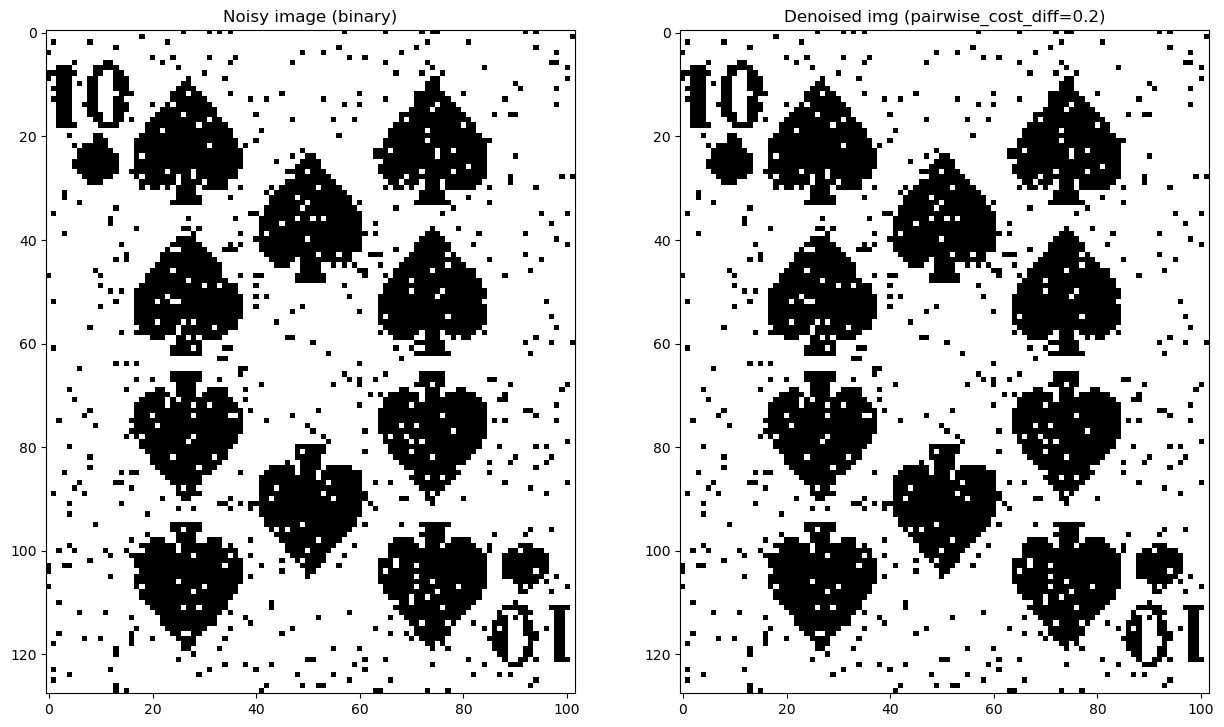

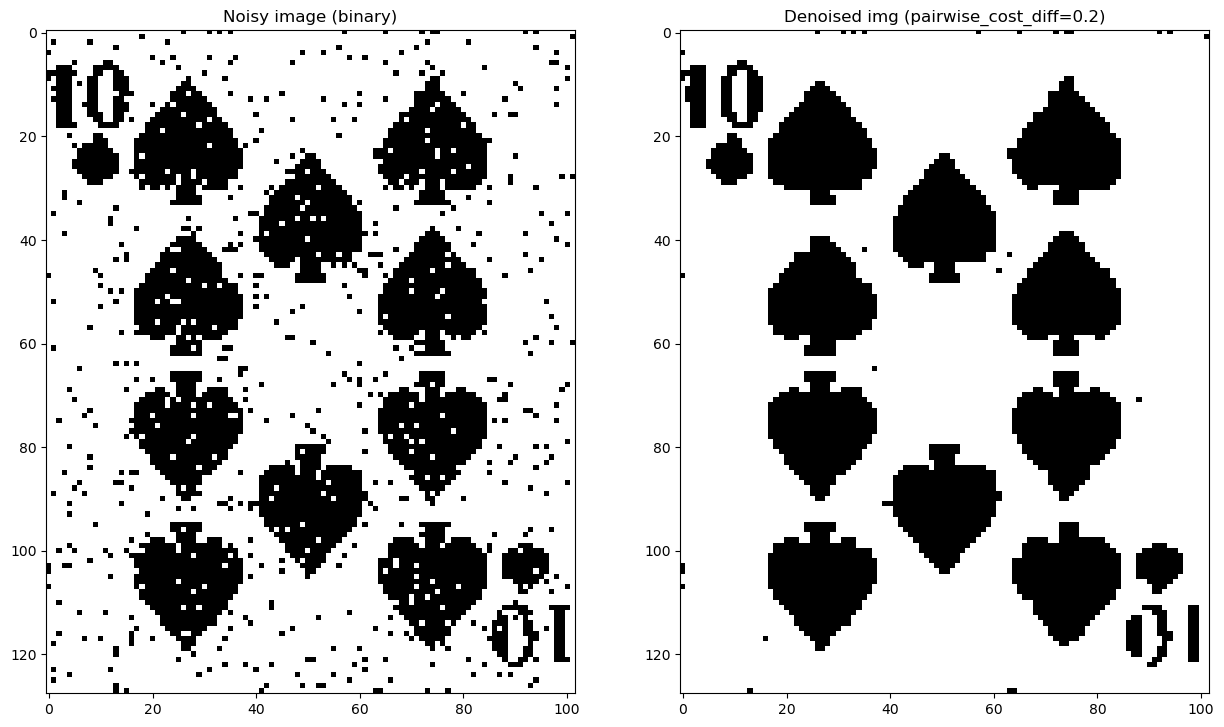

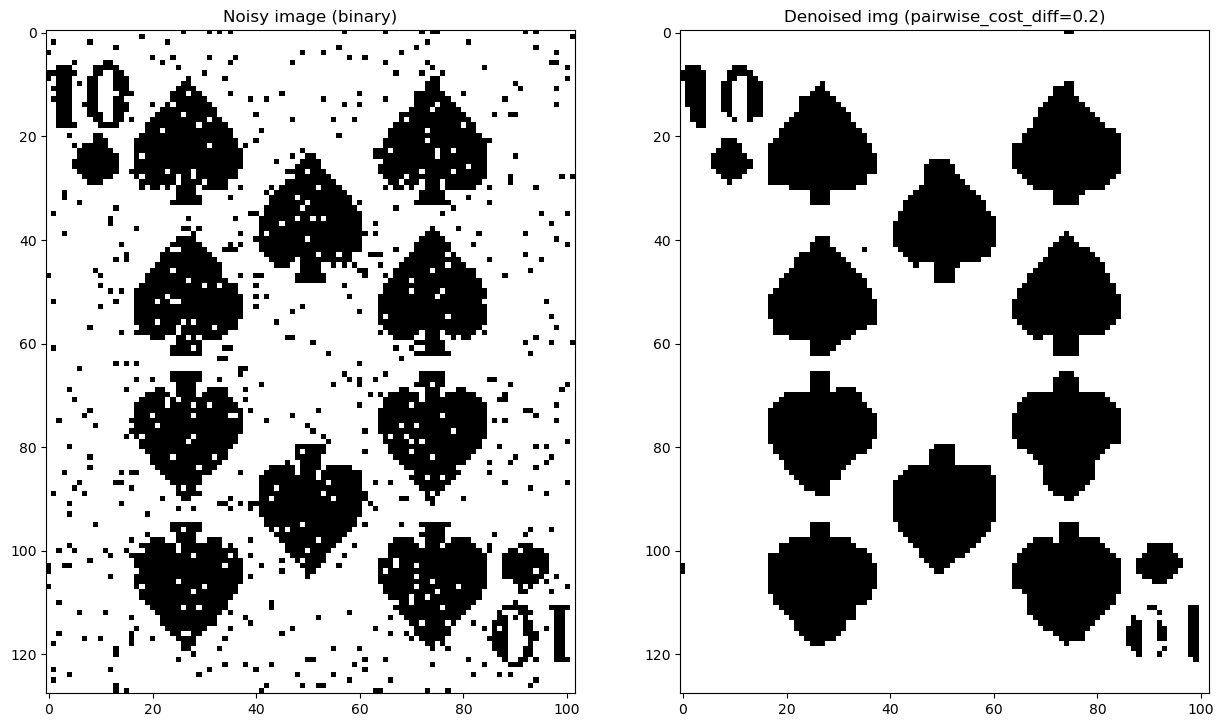

In [14]:
# Call solution for question 3
question_3(noisy_img, rho=0.7, pairwise_cost_same=0.005, pairwise_cost_diff=0.2)
question_3(noisy_img, rho=0.7, pairwise_cost_same=0.005, pairwise_cost_diff=0.35)
question_3(noisy_img, rho=0.7, pairwise_cost_same=0.005, pairwise_cost_diff=0.55)

Seems like pairwise_cost_diff=0.2 has no impact

## Task 4.
 Extend the algorithm in question 3 for a grayscale imagenoise2.png using Alpha Expansion Algorithm. <br> There are only three labels $[l_1, l_2, l_3]$ where $l_1=1$, $l_2=2$ and $l_3=3$ corresponding to gray values of (0,128,255) respectively. <br> Unary costs are defined as:

 $$

 $$